In [11]:
#imports
import os
import re
import sys
import struct
import numpy as np
import collections
from nltk.tokenize import sent_tokenize
from tensorflow.core.example import example_pb2
import networkx as nx
import pylab as plt

import json
import pytextrank

In [2]:
nx.__version__

'1.11'

---

## Text Summarization

---

In [2]:
# conda install spacy
# python -m spacy.en.download
# python -c "import spacy; spacy.load('en')"

#### Stage 1:

Perform statistical parsing/tagging on a document in JSON format

INPUTS: JSON doc for the text input

OUTPUT: JSON format ParsedGraf(id, sha1, graf)


In [3]:
# Using pytextrank
path_stage0 = "datasets/mih.json"
path_stage1 = "outputs/o1.json"

with open(path_stage1, 'w') as f:
    for graf in pytextrank.parse_doc(pytextrank.json_iter(path_stage0)):
        f.write("%s\n" % pytextrank.pretty_print(graf._asdict()))
        # to view output in this notebook
        print(pytextrank.pretty_print(graf))

["777", "7b982e54fa330a6854a0ed5397d49223fdc70645", [[1, "Compatibility", "compatibility", "NN", 1, 0], [0, "of", "of", "IN", 0, 1], [2, "systems", "system", "NNS", 1, 2], [0, "of", "of", "IN", 0, 3], [3, "linear", "linear", "JJ", 1, 4], [4, "constraints", "constraint", "NNS", 1, 5], [0, "over", "over", "IN", 0, 6], [0, "the", "the", "DT", 0, 7], [5, "set", "set", "NN", 1, 8], [0, "of", "of", "IN", 0, 9], [6, "natural", "natural", "JJ", 1, 10], [7, "numbers", "number", "NNS", 1, 11], [0, ".", ".", ".", 0, 12]]]
["777", "dfa572a4a2d2c0fd9254172d95b574b3f6067f63", [[8, "Criteria", "criteria", "NNP", 1, 13], [0, "of", "of", "IN", 0, 14], [1, "compatibility", "compatibility", "NN", 1, 15], [0, "of", "of", "IN", 0, 16], [0, "a", "a", "DT", 0, 17], [2, "system", "system", "NN", 1, 18], [0, "of", "of", "IN", 0, 19], [3, "linear", "linear", "NN", 1, 20], [9, "Diophantine", "diophantine", "NNP", 1, 21], [10, "equations", "equation", "NNS", 1, 22], [0, ",", ",", ".", 0, 23], [11, "strict", "stri

#### Stage 2:

Collect and normalize the key phrases from a parsed document

INPUTS: < stage1 >

OUTPUT: JSON format RankedLexeme(text, rank, ids, pos)

In [4]:
path_stage1 = "outputs/o1.json"
path_stage2 = "outputs/o2.json"

graph, ranks = pytextrank.text_rank(path_stage1)
pytextrank.render_ranks(graph, ranks)

with open(path_stage2, 'w') as f:
    for rl in pytextrank.normalize_key_phrases(path_stage1, ranks):
        f.write("%s\n" % pytextrank.pretty_print(rl._asdict()))
        # to view output in this notebook
        print(pytextrank.pretty_print(rl))

["systems", 0.12126445201773216, [2], "np", 1]
["types systems", 0.08570630601089342, [24, 2], "np", 1]
["minimal set", 0.06816332177984862, [19, 5], "np", 1]
["strict inequations", 0.04983533600449038, [11, 12], "np", 1]
["considered", 0.043715951844391, [15], "vbn", 2]
["types", 0.04285315300544671, [24], "nns", 3]
["mixed types", 0.04285315300544671, [33, 24], "np", 1]
["be", 0.03558870218143356, [14], "vb", 3]
["natural numbers", 0.03439402896373724, [6, 7], "np", 1]
["set", 0.03408166088992431, [5], "nn", 4]
["minimal generating sets", 0.03408166088992431, [19, 23, 5], "np", 1]
["solutions", 0.033892921989578426, [20], "nns", 3]
["linear constraints", 0.029908647386763194, [3, 4], "np", 1]
["diophantine", 0.02692982061787502, [9], "np", 1]
["linear diophantine equations", 0.02692201496702678, [3, 9, 10], "np", 1]
["solving", 0.0265895350793301, [32], "vbg", 1]
["inequations", 0.02491766800224519, [12], "nns", 2]
["nonstrict inequations", 0.02491766800224519, [13, 12], "np", 1]
["u

/Users/shivasj/anaconda/envs/harvard/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/shivasj/anaconda/envs/harvard/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/shivasj/anaconda/envs/harvard/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/shivasj/anaconda/envs/harvard/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is depreca

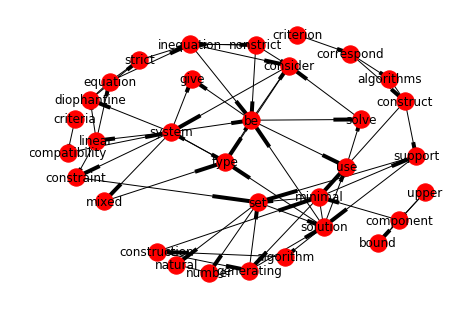

In [6]:
nx.draw(graph, with_labels=True) 
plt.show()

#### Stage 3:

Calculate a significance weight for each sentence, using MinHash to approximate a Jaccard distance from key phrases determined by TextRank

INPUTS: < stage1 > < stage2 >

OUTPUT: JSON format SummarySent(dist, idx, text)

In [7]:
path_stage1 = "outputs/o1.json"
path_stage2 = "outputs/o2.json"
path_stage3 = "outputs/o3.json"

kernel = pytextrank.rank_kernel(path_stage2)

with open(path_stage3, 'w') as f:
    for s in pytextrank.top_sentences(kernel, path_stage1):
        f.write(pytextrank.pretty_print(s._asdict()))
        f.write("\n")
        # to view output in this notebook
        print(pytextrank.pretty_print(s._asdict()))

{"dist": 0.06677187693979718, "idx": 0, "text": "Compatibility of systems of linear constraints over the set of natural numbers ."}
{"dist": 0.056191499776859666, "idx": 2, "text": "Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given ."}
{"dist": 0.053983648620151266, "idx": 1, "text": "Criteria of compatibility of a system of linear Diophantine equations , strict inequations , and nonstrict inequations are considered ."}
{"dist": 0.052709218147020676, "idx": 3, "text": "These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types ."}


#### Stage 4:

Summarize a document based on most significant sentences and key phrases

INPUTS: < stage2 > < stage3 >

OUTPUT: Markdown format

In [8]:
path_stage2 = "outputs/o2.json"
path_stage3 = "outputs/o3.json"

phrases = ", ".join(set([p for p in pytextrank.limit_keyphrases(path_stage2, phrase_limit=12)]))
sent_iter = sorted(pytextrank.limit_sentences(path_stage3, word_limit=150), key=lambda x: x[1])
s = []

for sent_text, idx in sent_iter:
    s.append(pytextrank.make_sentence(sent_text))

graf_text = " ".join(s)
print("**excerpts:** %s\n\n**keywords:** %s" % (graf_text, phrases,))

**excerpts:** Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types.

**keywords:** set, diophantine, minimal set, minimal generating sets, systems, solutions, linear diophantine equations, natural numbers, strict inequations, mixed types, types systems, types, linear constraints


#### Final Ouput

In [18]:
#pytextrank.parse_doc(pytextrank.json_iter(path_stage0))[0]
data = json.load(open(path_stage0))
print('Original Text:')
print('--------------')
print(data['text'])
print('Excerpt:')
print('--------')
print(graf_text)
print('Keywords:')
print('--------')
print(phrases)

Original Text:
--------------
Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types.
Excerpt:
--------
Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These cri

#### Statistical Parsing

In [24]:
path_stage0 = "datasets/lee.json"
path_stage1 = "outputs/lee_o1.json"

with open(path_stage1, 'w') as f:
    for graf in pytextrank.parse_doc(pytextrank.json_iter(path_stage0)):
        f.write("%s\n" % pytextrank.pretty_print(graf._asdict()))
        # to view output in this notebook
        print(pytextrank.pretty_print(graf))

["231", "8ae3383b37be39f1ac59168515ea64bbd37e1a2e", [[0, "After", "after", "IN", 0, 0], [34, "more", "more", "JJR", 1, 1], [0, "than", "than", "IN", 0, 2], [0, "four", "four", "CD", 0, 3], [35, "hours", "hour", "NNS", 1, 4], [0, "of", "of", "IN", 0, 5], [36, "tight", "tight", "JJ", 1, 6], [37, "play", "play", "NN", 1, 7], [0, "and", "and", "CC", 0, 8], [0, "a", "a", "DT", 0, 9], [38, "rapid-fire", "rapid-fire", "JJ", 1, 10], [39, "endgame", "endgame", "NN", 1, 11], [0, ",", ",", ".", 0, 12], [40, "Google", "google", "NNP", 1, 13], [0, "'s", "'s", "POS", 0, 14], [0, "artificially", "artificially", "RB", 0, 15], [41, "intelligent", "intelligent", "JJ", 1, 16], [42, "Go-playing", "go-play", "VB", 1, 17], [43, "computer", "computer", "NN", 1, 18], [2, "system", "system", "NN", 1, 19], [44, "has", "have", "VBZ", 1, 20], [45, "won", "win", "VBN", 1, 21], [0, "a", "a", "DT", 0, 22], [46, "second", "second", "JJ", 1, 23], [47, "contest", "contest", "NN", 1, 24], [0, "against", "against", "IN",

#### Ranked Keyphrases

In [25]:
path_stage1 = "outputs/lee_o1.json"
path_stage2 = "outputs/lee_o2.json"

graph, ranks = pytextrank.text_rank(path_stage1)
pytextrank.render_ranks(graph, ranks)

with open(path_stage2, 'w') as f:
    for rl in pytextrank.normalize_key_phrases(path_stage1, ranks):
        f.write("%s\n" % pytextrank.pretty_print(rl._asdict()))
        # to view output in this notebook
        print(pytextrank.pretty_print(rl))

["google", 0.026026255073889386, [40], "np", 6]
["many other games", 0.0216767982355798, [77, 78, 68], "np", 1]
["more win", 0.020073886137486792, [34, 45], "np", 1]
["lee sedol", 0.018149270708722718, [49, 50], "np", 8]
["match", 0.016979080481930604, [54], "np", 1]
["alphago", 0.016713162984516014, [60], "np", 4]
["more than four hours", 0.01648639508597453, [34, 0, 0, 35], "np", 1]
["wednesday afternoon", 0.01638584926949149, [155, 83], "np", 2]
["is", 0.014809549729303425, [14], "vbz", 12]
["seoul", 0.013386735372663083, [56], "np", 2]
["four seasons hotel", 0.013340431412067621, [84, 85, 86], "np", 1]
["skillful google machine", 0.013013127536944693, [57, 40, 58], "np", 1]
["afternoon", 0.012994365708139922, [83], "np", 1]
["machine-learning techniques", 0.012768573980693533, [93, 94], "np", 1]
["search engine results", 0.012240995646780077, [110, 111, 112], "np", 1]
["tight play", 0.011806382477747795, [36, 37], "np", 1]
["world chess champion gary", 0.011742091089317662, [139, 7

#### Extractive Summarization

In [26]:
path_stage1 = "outputs/lee_o1.json"
path_stage2 = "outputs/lee_o2.json"
path_stage3 = "outputs/lee_o3.json"

kernel = pytextrank.rank_kernel(path_stage2)

with open(path_stage3, 'w') as f:
    for s in pytextrank.top_sentences(kernel, path_stage1):
        f.write(pytextrank.pretty_print(s._asdict()))
        f.write("\n")
        # to view output in this notebook
        print(pytextrank.pretty_print(s._asdict()))

{"dist": 0.02550877977106419, "idx": 16, "text": "But AlphaGo could not ."}
{"dist": 0.02440609391223902, "idx": 10, "text": "Lee Sedol is widely-regarded as the top Go player of the last decade , after winning more international titles than all but one other player ."}
{"dist": 0.02352312242281724, "idx": 12, "text": "Although AlphaGo topped Lee Sedol in the match 's first game on Wednesday afternoon , the outcome of Game Two was no easier to predict ."}
{"dist": 0.02247625911222141, "idx": 4, "text": "Game Three is set for Saturday afternoon inside Seoul 's Four Seasons hotel .  "}
{"dist": 0.022067365299533476, "idx": 2, "text": "The Korean-born Lee Sedol will go down in defeat unless he takes each of the match 's last three games ."}
{"dist": 0.020157730264876748, "idx": 1, "text": "The surprisingly skillful Google machine , known as AlphaGo , now needs only one more win to claim victory in the match ."}
{"dist": 0.019894139008120475, "idx": 15, "text": "The thing to realize is tha

In [27]:
path_stage2 = "outputs/lee_o2.json"
path_stage3 = "outputs/lee_o3.json"

phrases = ", ".join(set([p for p in pytextrank.limit_keyphrases(path_stage2, phrase_limit=12)]))
sent_iter = sorted(pytextrank.limit_sentences(path_stage3, word_limit=150), key=lambda x: x[1])
s = []

for sent_text, idx in sent_iter:
    s.append(pytextrank.make_sentence(sent_text))

graf_text = " ".join(s)

#### Final Ouput

In [28]:
data = json.load(open(path_stage0))
print('Original Text:')
print('--------------')
print(data['text'])
print('Excerpt:')
print('--------')
print(graf_text)
print('Keywords:')
print('--------')
print(phrases)

Original Text:
--------------
After more than four hours of tight play and a rapid-fire endgame, Google's artificially intelligent Go-playing computer system has won a second contest against grandmaster Lee Sedol, taking a two-games-to-none lead in their historic best-of-five match in downtown Seoul.  The surprisingly skillful Google machine, known as AlphaGo, now needs only one more win to claim victory in the match. The Korean-born Lee Sedol will go down in defeat unless he takes each of the match's last three games. Though machines have beaten the best humans at chess, checkers, Othello, Scrabble, Jeopardy!, and so many other games considered tests of human intellect, they have never beaten the very best at Go. Game Three is set for Saturday afternoon inside Seoul's Four Seasons hotel.  The match is a way of judging the suddenly rapid progress of artificial intelligence. One of the machine-learning techniques at the heart of AlphaGo has already reinvented myriad online services insi

---

## Sentiment Analysis

---

In [33]:
import numpy as np
import re
from nltk.corpus import stopwords
from gensim.parsing.porter import PorterStemmer

stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

Using TensorFlow backend.


In [34]:
next(stream_docs(path='./movie_data.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

In [47]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [48]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

clf = SGDClassifier(loss='log', random_state=1, n_iter=1)
doc_stream = stream_docs(path='./movie_data.csv')

/Users/shivasj/anaconda/envs/harvard/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [49]:
import pyprind
pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:22


In [50]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.867


In [51]:
clf = clf.partial_fit(X_test, y_test)

### Serializing fitted scikit-learn estimators

In [52]:
import pickle
import os

dest = os.path.join('TextSummarizer/textsummarizersvc/movieclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)

pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'), protocol=4)   
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

In [53]:
from spacy.en import English
nlp = English()
sent = "I shot an elephant"
doc=nlp(sent)

sub_toks = [tok for tok in doc if (tok.dep_ == "nsubj") ]

print(sub_toks) 

[I]


In [54]:
print(doc)

I shot an elephant


In [56]:
for tok in doc:
    print(tok,tok.dep_)

I nsubj
shot ROOT
an det
elephant dobj


In [57]:
sent = "What is regression?"
doc=nlp(sent)
for tok in doc:
    print(tok,tok.dep_)

What attr
is ROOT
regression nsubj
? punct


In [59]:
sent = "What is the purpose of a QQ plot for regression?"
doc=nlp(sent)
for tok in doc:
    print(tok,tok.dep_)

What attr
is ROOT
the det
purpose nsubj
of prep
a det
QQ compound
plot pobj
for prep
regression pobj
? punct


In [60]:
sent = "Describe the fundamental differences between stacking and boosting."
doc=nlp(sent)
for tok in doc:
    print(tok,tok.dep_)

Describe ROOT
the det
fundamental amod
differences dobj
between prep
stacking pcomp
and cc
boosting conj
. punct


In [61]:
sent = "How are eigenvalues and eigenvectors related to PCA?"
doc=nlp(sent)
for tok in doc:
    print(tok,tok.dep_)

How advmod
are ROOT
eigenvalues attr
and cc
eigenvectors conj
related acl
to prep
PCA pobj
? punct


In [62]:
sent = "Compare/contrast a random forest and an isolation tree"
doc=nlp(sent)
for tok in doc:
    print(tok,tok.dep_)

Compare ROOT
/ punct
contrast dobj
a det
random amod
forest dobj
and cc
an det
isolation compound
tree conj
